# Øving 11 - TMA4105

In [1]:
%matplotlib inline

from numpy import *
from numpy.linalg import norm, solve
from matplotlib.pyplot import *
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
rcParams.update(newparams)

In [25]:
def ode_adaptive(f, x0, xend, y0, h0, tol=1.e-6, method=bogacki_shampine):
    # Adaptive solver for ODEs
    #    y' = f(x,y), y(x0)=y0
    # 
    # Input: the function f, x0, xend, and the initial value y0
    #        intial stepsize h, the tolerance tol, 
    #         and a function (method) implementing one step of a pair.
    # Ut: Array med x- og y- verdier. 
    
    y_num = array([y0])    # Array for the solutions y
    x_num = array([x0])    # Array for the x-values

    xn = x0                # Running values for  x, y and the stepsize h
    yn = y0 
    h = h0
    Maxcall = 1000000        # Maximum allowed calls of method
    ncall = 0
    
    # Main loop
    while xn < xend - 1.e-10:               # Buffer for truncation error
        # Adjust the stepsize for the last step
        if xn + h > xend:                   
            h = xend - xn 
        
        # Gjør et steg med valgt metode
        x_try, y_try, error_estimate, p = method(f, xn, yn, h)
        ncall = ncall + 1
        
        if error_estimate <= tol:   
            # Solution accepted, update x and y
            xn = x_try    
            yn = y_try
            # Store the solutions 
            y_num = concatenate((y_num, array([yn])))
            x_num = append(x_num, xn)
        
        # else: The step rejectes and nothing is updated. 
        
        # Adjust the stepsize
        h = 0.8*(tol/error_estimate)**(1/(p+1))*h
        
        # Stop with a warning in the case of max calls to method
        if ncall > Maxcall:
            print('Maximum number of method calls')
            return x_num, y_num

    # Some diagnostic output
    print('Number of accepted steps = ', len(x_num)-1)
    print('Number of rejected steps = ', ncall - len(x_num)+1)
    return x_num, y_num

### Oppgave 1

In [ ]:
def lotka_volterra(x, y):
    alpha, beta, delta, gamma = 2, 1, 0.5, 1     # Set the parameters
    dy = array([alpha*y[0]-beta*y[0]*y[1],       # 
                delta*y[0]*y[1]-gamma*y[1]])
    return dy

In [8]:
# Implementasjon av Bogacki-Shampine
def bogacki_shampine(f, x, y, h):    
    k1 = f(x, y)
    k2 = f(x + 0.5*h, y + 0.5*h*k1)
    k3 = f(x + 0.75*h, y + 0.75*h*k2)
    
    y_next = y + 2/9*h*k1 + 1/3*h*k2 + 4/9*h*k3
    
    k4 = f(x + h, y_next)
    
    z_next = y + 7/24*h*k1 + 1/4*h*k2 + 1/3*h*k3 + 1/8*h*k4
    
    x_next = x + h
    error_estimate = 0.5*h*norm(y_next - z_next)
    
    p = 3
    return x_next, y_next, error_estimate, p

In [23]:
# Implementasjon av Heun-Euler
def heun_euler(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_next = y + 0.5*h*(k1+k2)
    x_next = x + h
    error_estimate = 0.5*h*norm(k2-k1)
    
    p = 1
    return x_next, y_next, error_estimate, p

#### Løsning med bruk av Bogacki-Shampine


Tolerance: 10^-3:
Number of accepted steps =  87
Number of rejected steps =  12

Tolerance: 10^-5:
Number of accepted steps =  262
Number of rejected steps =  1

Tolerance: 10^-7:
Number of accepted steps =  828
Number of rejected steps =  1


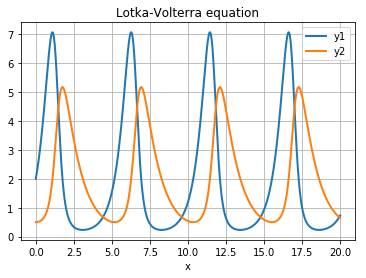

In [22]:
x0, xend = 0, 20
y0 = array([2, 0.5])

for i in range(3, 8, 2):
    print(f'\nTolerance: 10^-{i}:')
    x_lv, y_lv = ode_adaptive(lotka_volterra, x0, xend, y0, 1, tol=1 / 10**i, method=bogacki_shampine) 

plot(x_lv, y_lv);
xlabel('x')
title('Lotka-Volterra equation')
grid(True)
legend(['y1','y2'], loc=1);

#### Løsning med bruk av Heun-Euler


Tolerance: 10^-3:
Number of accepted steps =  1357
Number of rejected steps =  1

Tolerance: 10^-5:
Number of accepted steps =  13568
Number of rejected steps =  1

Tolerance: 10^-7:
Number of accepted steps =  135674
Number of rejected steps =  1


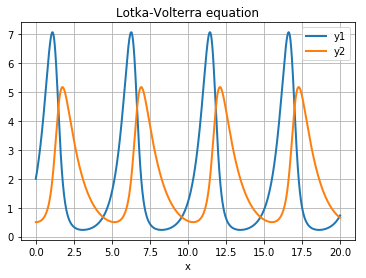

In [26]:
x0, xend = 0, 20
y0 = array([2, 0.5])

for i in range(3, 8, 2):
    print(f'\nTolerance: 10^-{i}:')
    x_lv, y_lv = ode_adaptive(lotka_volterra, x0, xend, y0, 1, tol=1 / 10**i, method=heun_euler) 

plot(x_lv, y_lv);
xlabel('x')
title('Lotka-Volterra equation')
grid(True)
legend(['y1','y2'], loc=1);

##### Konklusjon
Ser at Bogacki-Shampine bruker betydelig færre steg for å oppnå tilsvarende nøyaktighet som Heun-Euler.

### Oppgave 3 c)

In [32]:
def ode_solver(f, x0, xend, y0, h, method):
    # Generic solver for ODEs
    #    y' = f(x,y), y(a)=y0
    # Input: f, the integration interval x0 and xend, 
    #        the stepsize h and the method of choice.  
    #   
    # Output: Arrays with the x- and the corresponding y-values. 
    
    # Initializing:
    y_num = array([y0])    # Array for the solution y 
    x_num = array([x0])    # Array for the x-values

    xn = x0                # Running values for x and y
    yn = y0 

    # Main loop
    while xn < xend - 1.e-10:            # Buffer for truncation errors        
        xn, yn = method(f, xn, yn, h)    # Do one step by the method of choice
        
        # Extend the arrays for x and y
        y_num = concatenate((y_num, array([yn])))
        x_num = append(x_num,xn)
        
    return x_num, y_num

In [27]:
# Implementasjon av 3. ordens Runge-Kutta
def rk3(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h/2, y + h/2*k1)
    k3 = f(x + 3/4*h, y + 3/4*h*k2)
    
    y_next = y + h/9 * (2*k1 + 3*k2 + 4*k3)
    return x + h, y_next

def f(x, y):
    return array([
        -41*y[0] + 38*y[1],
        19*y[0] -22*y[1]
    ])

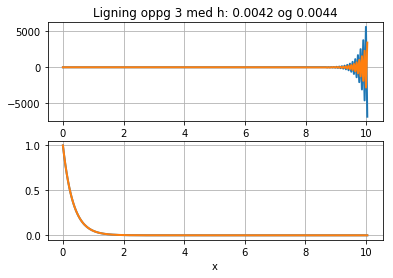

In [49]:
y0 = array([1, 1])
x0, xend = 0, 10

h = 0.044
x_lv, y_lv = ode_solver(f, x0, xend, y0, h=h, method=rk3) 

subplot(2,1,1)
title('Ligning oppg 3 med h: 0.0042 og 0.0044')
plot(x_lv, y_lv);

h = 0.042
x_lv, y_lv = ode_solver(f, x0, xend, y0, h=h, method=rk3) 

subplot(2,1,2)
plot(x_lv, y_lv);
xlabel('x')
grid(True)



##### Konklusjon
Som man kan se av de to plottene er det stor forskjell på stabiliteten på de to forskjellige løsningene der den første er så vidt over den teoretiske grensen for h, og den andre er så vidt innafor.

### Oppgave 4 b)

In [57]:
def implicit_midpoint(rhs, x, y, h):
    A, gx = rhs(x+h)
    d = len(gx)
    M = eye(d) - h*A
    b = y + h*gx
    y_next = solve(M, b)
    x_next = x+h
    return x_next, y_next

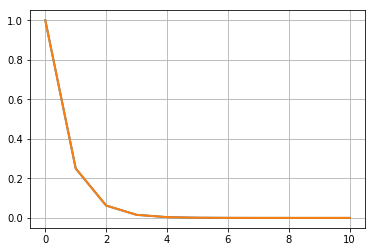

In [62]:
# Høyresiden fra oppgave 3
def rhs(x):
    gx = array([0, 0])
    A = array([[-41, 38],[19, -22]])
    return A, gx

# Y0-verdiene fra oppgave 3 også
y0 = array([1, 1])
x0, xend = 0, 10

# Veldig stor h
h = 1

x_num, y_num = ode_solver(rhs, x0, xend, y0, h, method=implicit_midpoint)
plot(x_num, y_num);

##### Konklusjon
Her funker det selv med h=1, som er mye høyre enn den teoretiske grenser for den eksplisitte metoden rk3.

### Oppgave 5 c)

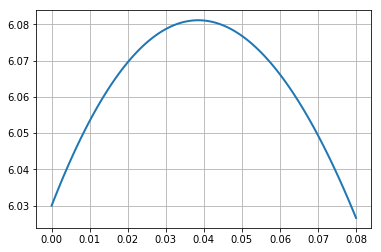

In [67]:
def f(theta):
    return 34.26*theta**3 - 37.085*theta**2 + 2.705*theta + 6.03


xdata = linspace(0, .08, 101)
ydata = f(xdata)

plot(xdata, ydata);
    

Tror ikke dette ble helt riktig...